In [1]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [2]:
!pwd

/home/ubuntu/project/tflite-speech-recognition


In [3]:
# Dataset path and view possible targets
dataset_path = '/home/ubuntu/project/dataset/speech_commands_v0.02'
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)

go
eight
wow
house
_background_noise_
follow
down
happy
off
four
backward
learn
stop
forward
three
zero
two
on
marvin
bed
sheila
right
bird
tree
nine
no
six
visual
seven
five
dog
cat
up
left
yes
one


In [4]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if name in ["_background_noise_",'yes','no','stop']]
print(all_targets)

['_background_noise_', 'stop', 'no', 'yes']


In [5]:
# Leave off background noise set
all_targets.remove('_background_noise_')
print(all_targets)

['stop', 'no', 'yes']


In [6]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

3872
3941
4044
Total samples: 11857


In [7]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [8]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

/home/ubuntu/project/dataset/speech_commands_v0.02/stop
/home/ubuntu/project/dataset/speech_commands_v0.02/no
/home/ubuntu/project/dataset/speech_commands_v0.02/yes


In [9]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.]), array([2., 2., 2., ..., 2., 2., 2.])]
3872
3941
4044


In [10]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [11]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [12]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

11857
11857


In [13]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [14]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [15]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [16]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [17]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1
        

Dropped: 2 (16, 10)
Dropped: 13 (16, 8)
Dropped: 16 (16, 14)
Dropped: 48 (16, 14)
Dropped: 81 (16, 9)
Dropped: 103 (16, 13)
Dropped: 104 (16, 11)
Dropped: 107 (16, 12)
Dropped: 134 (16, 11)
Dropped: 139 (16, 8)
Dropped: 176 (16, 15)
Dropped: 187 (16, 14)
Dropped: 190 (16, 11)
Dropped: 192 (16, 13)
Dropped: 194 (16, 12)
Dropped: 238 (16, 14)
Dropped: 239 (16, 11)
Dropped: 264 (16, 10)
Dropped: 271 (16, 11)
Dropped: 290 (16, 13)
Dropped: 294 (16, 15)
Dropped: 295 (16, 14)
Dropped: 298 (16, 14)
Dropped: 320 (16, 15)
Dropped: 323 (16, 13)
Dropped: 340 (16, 14)
Dropped: 354 (16, 13)
Dropped: 355 (16, 14)
Dropped: 402 (16, 9)
Dropped: 413 (16, 15)
Dropped: 417 (16, 11)
Dropped: 422 (16, 12)
Dropped: 423 (16, 15)
Dropped: 424 (16, 13)
Dropped: 460 (16, 13)
Dropped: 481 (16, 13)
Dropped: 483 (16, 13)
Dropped: 486 (16, 15)


In [18]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.076


In [21]:
!pip install playsound

  Using cached playsound-1.2.2-py2.py3-none-any.whl (6.0 kB)


MFCCs: [[-4.98283617e+01 -4.89435885e+01 -3.99669893e+01 -2.46875992e+01
  -1.72528035e+01 -1.49813567e+01 -1.58656459e+01 -2.01017572e+01]
 [ 6.27610722e+00  7.15080681e+00  1.06715137e+01  9.24531212e+00
   8.67011343e+00  9.10725300e+00  1.06876140e+01  1.22333438e+01]
 [-1.65539708e-01  3.72726341e-01  3.81819837e+00  1.19752722e+00
  -1.50765084e+00 -3.29023703e+00 -3.34100025e+00 -2.79931055e+00]
 [ 5.84946752e-01  8.77622050e-01  1.01898160e+00 -2.06539638e+00
  -3.79362499e+00 -5.12851310e+00 -5.39170317e+00 -4.66169811e+00]
 [ 8.37171774e-01  4.37475986e-01 -1.54289040e+00 -2.28229981e+00
  -1.48071167e+00 -4.91495758e-01  3.71401390e-01  2.47666129e-01]
 [ 1.67191548e+00  1.68434829e+00 -1.41556820e+00 -1.93820989e+00
  -1.55047891e+00 -8.97957357e-01  6.99672340e-01  2.54530839e+00]
 [ 5.43928187e-01  9.75544675e-02 -1.69508434e+00 -1.93744705e-01
  -5.26382864e-01 -1.28344831e+00 -1.95240718e+00 -2.37010841e+00]
 [ 1.48231323e+00  8.37324627e-01 -4.24164640e-01  3.32171967e

ModuleNotFoundError: No module named 'gi'

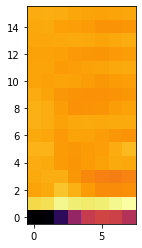

In [22]:
# TEST: Test shorter MFCC
# !pip install playsound
from playsound import playsound

idx = 13

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
playsound(path)

In [23]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [24]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 2 (16, 10)
Dropped: 13 (16, 8)
Dropped: 16 (16, 14)
Dropped: 48 (16, 14)
Dropped: 81 (16, 9)
Dropped: 103 (16, 13)
Dropped: 104 (16, 11)
Dropped: 107 (16, 12)
Dropped: 134 (16, 11)
Dropped: 139 (16, 8)
Dropped: 176 (16, 15)
Dropped: 187 (16, 14)
Dropped: 190 (16, 11)
Dropped: 192 (16, 13)
Dropped: 194 (16, 12)
Dropped: 238 (16, 14)
Dropped: 239 (16, 11)
Dropped: 264 (16, 10)
Dropped: 271 (16, 11)
Dropped: 290 (16, 13)
Dropped: 294 (16, 15)
Dropped: 295 (16, 14)
Dropped: 298 (16, 14)
Dropped: 320 (16, 15)
Dropped: 323 (16, 13)
Dropped: 340 (16, 14)
Dropped: 354 (16, 13)
Dropped: 355 (16, 14)
Dropped: 402 (16, 9)
Dropped: 413 (16, 15)
Dropped: 417 (16, 11)
Dropped: 422 (16, 12)
Dropped: 423 (16, 15)
Dropped: 424 (16, 13)
Dropped: 460 (16, 13)
Dropped: 481 (16, 13)
Dropped: 483 (16, 13)
Dropped: 486 (16, 15)
Dropped: 510 (16, 13)
Dropped: 511 (16, 13)
Dropped: 525 (16, 12)
Dropped: 532 (16, 14)
Dropped: 534 (16, 13)
Dropped: 544 (16, 9)
Dropped: 585 (16, 11)
Dropped: 586 (16, 15)

Dropped: 5060 (16, 15)
Dropped: 5063 (16, 11)
Dropped: 5071 (16, 11)
Dropped: 5080 (16, 10)
Dropped: 5093 (16, 10)
Dropped: 5118 (16, 12)
Dropped: 5157 (16, 14)
Dropped: 5168 (16, 15)
Dropped: 5199 (16, 5)
Dropped: 5230 (16, 15)
Dropped: 5240 (16, 11)
Dropped: 5245 (16, 7)
Dropped: 5258 (16, 13)
Dropped: 5295 (16, 10)
Dropped: 5338 (16, 15)
Dropped: 5348 (16, 10)
Dropped: 5349 (16, 13)
Dropped: 5353 (16, 13)
Dropped: 5392 (16, 11)
Dropped: 5422 (16, 7)
Dropped: 5458 (16, 15)
Dropped: 5459 (16, 13)
Dropped: 5465 (16, 15)
Dropped: 5478 (16, 11)
Dropped: 5483 (16, 13)
Dropped: 5498 (16, 15)
Dropped: 5499 (16, 10)
Dropped: 5522 (16, 13)
Dropped: 5537 (16, 12)
Dropped: 5544 (16, 7)
Dropped: 5576 (16, 8)
Dropped: 5584 (16, 12)
Dropped: 5607 (16, 13)
Dropped: 5620 (16, 12)
Dropped: 5628 (16, 12)
Dropped: 5637 (16, 12)
Dropped: 5651 (16, 12)
Dropped: 5665 (16, 15)
Dropped: 5692 (16, 12)
Dropped: 5696 (16, 15)
Dropped: 5712 (16, 13)
Dropped: 5726 (16, 12)
Dropped: 5738 (16, 9)
Dropped: 5747 (16

Dropped: 35 (16, 13)
Dropped: 40 (16, 15)
Dropped: 43 (16, 9)
Dropped: 52 (16, 14)
Dropped: 56 (16, 14)
Dropped: 80 (16, 15)
Dropped: 88 (16, 11)
Dropped: 91 (16, 12)
Dropped: 108 (16, 9)
Dropped: 120 (16, 13)
Dropped: 122 (16, 14)
Dropped: 128 (16, 12)
Dropped: 136 (16, 14)
Dropped: 169 (16, 13)
Dropped: 172 (16, 14)
Dropped: 224 (16, 12)
Dropped: 227 (16, 9)
Dropped: 237 (16, 13)
Dropped: 247 (16, 15)
Dropped: 256 (16, 11)
Dropped: 276 (16, 13)
Dropped: 308 (16, 8)
Dropped: 309 (16, 12)
Dropped: 325 (16, 14)
Dropped: 326 (16, 12)
Dropped: 331 (16, 13)
Dropped: 334 (16, 7)
Dropped: 344 (16, 14)
Dropped: 362 (16, 13)
Dropped: 381 (16, 11)
Dropped: 396 (16, 10)
Dropped: 403 (16, 15)
Dropped: 415 (16, 11)
Dropped: 422 (16, 14)
Dropped: 428 (16, 12)
Dropped: 430 (16, 14)
Dropped: 431 (16, 10)
Dropped: 443 (16, 13)
Dropped: 445 (16, 10)
Dropped: 449 (16, 11)
Dropped: 452 (16, 10)
Dropped: 453 (16, 12)
Dropped: 497 (16, 9)
Dropped: 515 (16, 14)
Dropped: 533 (16, 6)
Dropped: 543 (16, 11)
Dro

In [25]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [26]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [27]:
len(feature_sets['x_train'])

8767

In [28]:
print(feature_sets['y_val'])

[0. 0. 1. ... 2. 0. 1.]


In [29]:
!ls

01-speech-commands-mfcc-extraction.ipynb  all_targets_mfcc_sets.npz
02-speech-commands-mfcc-classifier.ipynb  Images
03-tflite-model-converter.ipynb		  README.md
04-rpi-tflite-audio-stream.py		  requirements.txt
05-rpi-tflite-audio-switch.py		  wake_word_stop_lite.tflite
